# Customer Segmentation

The guided tutorial that accompanies this code is located at https://difit.datakind.org/. 

The tutorial content begins at the "Tutorial" heading. The first several cells are prep work to use the tutorial including setting up the environment and creating the synthetic datasets for the tutorial. Thus, these are necessary to run if you would like to use the tutorial, however, they are not included in the tutorial text. 

# Prep Work

## Import Libraries

In [5]:
import pyod
from pyod.models.ecod import ECOD
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from kmodes.kprototypes import KPrototypes
import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px
import nbformat
from sklearn.manifold import TSNE


## Create Synthetic Datasets

In [6]:
# Set seed for reproducibility
np.random.seed(37)

# Parameters
num_samples = 2000

cluster_centers = {
    ('Bogota', 6) : [700, 55000000, 50, 1.5],
    ('Bogota', 12) : [700,55000000, 50, 1.5],
    ('Medellin', 6) : [625, 47500000, 40, 1],
    ('Medellin', 12) : [625, 47500000, 40, 1],
    ('Cartagena', 6) : [550, 40000000, 30, .5],
    ('Cartagena', 12) : [550, 40000000, 30, .5]
}

# User IDs
user_id = np.arange(1, num_samples + 1)

# Gender: Male or Female
gender = np.random.choice(['male', 'female'], size=num_samples)

# Location: Bogota, Medellin, Cartagena
location = np.random.choice(['Bogota', 'Medellin', 'Cartagena'], size=num_samples)

# Current loan duration: 6 or 12 months
number_of_installments = np.random.choice([6, 12], size=num_samples)

credit_scores = []
incomes = []
ages = []
number_past_loans = []
loan_orig_amts = []
for i in range(num_samples):
    loc = location[i]
    ltype = number_of_installments[i]
    center = cluster_centers[(loc, ltype)]
    credit_score = np.random.normal(loc=center[0], scale=15)
    income = np.random.normal(loc=center[1], scale=500000)
    age = np.random.normal(loc=center[2], scale=5)
    number_past_loan = np.random.lognormal(mean=center[3], sigma=.1)
    loan_multiplier = {6: 0.05, 12: 0.1}
    loan_orig_amt = np.random.normal(loc=income*.05, scale=300000)
    
    credit_scores.append(credit_score)
    incomes.append(income)
    ages.append(age)
    number_past_loans.append(number_past_loan)
    loan_orig_amts.append(loan_orig_amt)

credit_scores = np.array(credit_scores)
incomes = np.array(incomes)
ages = np.array(ages)
number_past_loans = np.array(number_past_loans)
loan_orig_amts = np.array(loan_orig_amts)

#cast ages and credit scores to integers
ages = ages.astype(int)
credit_scores = credit_scores.astype(int)
number_past_loans = number_past_loans.astype(int)

ages = np.clip(ages, 18, 85)
credit_scores = np.clip(credit_scores, 350, 850)

# Account open: 95% True
account_open = np.random.choice([True, False], size=num_samples, p=[0.95, 0.05])

# Installment amount: Loan amount divided by duration
installment_amt = [loan_orig_amts[i] / number_of_installments[i] for i in range(num_samples)]

# Installments paid: Less than or equal to current loan duration
installments_paid = [np.random.randint(0, duration) for duration in number_of_installments]

# On-time payments: Skewed closer to installments paid
on_time_payments = [max(0, np.random.binomial(paid, 0.8)) for paid in installments_paid]

# Late payments: Installments paid minus on-time payments
late_payments = [paid - on_time for paid, on_time in zip(installments_paid, on_time_payments)]

# Account delinquent: 10% of accounts, negatively correlated with income and credit score
account_delq = [late > 0 and np.random.rand() < 0.1 for late in late_payments]

# Number of past defaults: Less than number of past loans, skewed to zero
number_past_default = [max(0, min(np.random.binomial(n, 0.2), n)) for n in number_past_loans]

# Generate payment_date (random int between 1 and 28)
payment_date = [np.random.randint(1, 29) for _ in range(num_samples)]

# Create DataFrame
df = pd.DataFrame({
    'user_id': user_id,
    'age': ages,
    'gender': gender,
    'location': location,
    'credit_score': credit_scores,
    'account_open': account_open,
    'income': incomes,
    'number_of_installments': number_of_installments,
    'loan_orig_amt': loan_orig_amts,
    'installment_amt': installment_amt,
    'installments_paid': installments_paid,
    'on_time_payments': on_time_payments,
    'late_payments': late_payments,
    'account_delq': account_delq,
    'number_past_loans': number_past_loans,
    'number_past_default': number_past_default,
    'payment_date': payment_date
})
#make one age observation missing
df.loc[0, 'age'] = np.nan

#replace one credit score wih 1600
df.loc[1, 'credit_score'] = 1200


# Tutorial

## Module 3: Exploratory Data Analysis (EDA)

In [7]:
df.head(n =10)

,user_id,age,gender,location,credit_score,account_open,income,number_of_installments,loan_orig_amt,installment_amt,installments_paid,on_time_payments,late_payments,account_delq,number_past_loans,number_past_default,payment_date
0,1,NaN,female,Bogota,698,True,55091685.52,6,2730912.73,455152.12,2,1,1,False,4,2,21
1,2,38.00,female,Medellin,1200,True,46957191.78,12,2283919.94,190326.66,0,0,0,False,3,1,22
2,3,50.00,male,Bogota,711,True,55060072.07,12,3084222.42,257018.53,6,4,2,False,4,2,23
3,4,33.00,female,Cartagena,545,True,40542930.85,12,2020920.77,168410.06,0,0,0,False,1,0,28
4,5,43.00,male,Bogota,708,True,54729839.35,6,2549207.00,424867.83,3,2,1,False,4,1,3
5,6,53.00,female,Bogota,725,True,55289607.35,6,3240824.16,540137.36,2,2,0,False,5,0,6
6,7,33.00,male,Medellin,631,True,47570085.23,12,2562102.69,213508.56,2,1,1,False,2,1,12
7,8,44.00,male,Bogota,685,True,54822595.81,12,2602239.08,216853.26,1,1,0,False,4,1,4
8,9,41.00,female,Medellin,615,True,47229006.06,12,2503581.19,208631.77,0,0,0,False,2,0,13
9,10,31.00,female,Cartagena,551,True,39905013.01,12,2388009.98,199000.83,1,1,0,False,1,0,19


In [8]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,user_id,age,credit_score,income,number_of_installments,loan_orig_amt,installment_amt,installments_paid,on_time_payments,late_payments,number_past_loans,number_past_default,payment_date
count,2000.00,1999.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00,2000.00
mean,1000.50,39.37,625.25,47557455.53,8.93,2377459.52,299419.17,3.88,3.07,0.80,2.42,0.49,14.52
std,577.49,9.37,63.60,6103193.44,3.00,426828.39,113368.97,3.04,2.53,1.05,1.29,0.69,8.12
min,1.00,18.00,502.00,38577361.37,6.00,1087705.85,90642.15,0.00,0.00,0.00,1.00,0.00,1.00
25%,500.75,32.00,561.00,40378030.44,6.00,2077080.14,199806.11,1.00,1.00,0.00,1.00,0.00,8.00
50%,1000.50,39.00,625.00,47550340.72,6.00,2385647.89,273904.06,3.00,3.00,0.00,2.00,0.00,14.50
75%,1500.25,47.00,689.00,54683123.06,12.00,2673570.54,399800.05,5.00,5.00,1.00,4.00,1.00,22.00
max,2000.00,63.00,1200.00,56528414.56,12.00,3465409.79,577568.30,11.00,11.00,7.00,6.00,4.00,28.00


In [9]:
print(df['location'].value_counts())
print(df['gender'].value_counts())

location
Medellin     691
Bogota       661
Cartagena    648
Name: count, dtype: int64
gender
female    1011
male       989
Name: count, dtype: int64


In [10]:
df.dtypes

user_id                     int64
age                       float64
gender                     object
location                   object
credit_score                int64
account_open                 bool
income                    float64
number_of_installments      int64
loan_orig_amt             float64
installment_amt           float64
installments_paid           int64
on_time_payments            int64
late_payments               int64
account_delq                 bool
number_past_loans           int64
number_past_default         int64
payment_date                int64
dtype: object

In [11]:
print(df.isnull().sum())

user_id                   0
age                       1
gender                    0
location                  0
credit_score              0
account_open              0
income                    0
number_of_installments    0
loan_orig_amt             0
installment_amt           0
installments_paid         0
on_time_payments          0
late_payments             0
account_delq              0
number_past_loans         0
number_past_default       0
payment_date              0
dtype: int64


### Visualizations

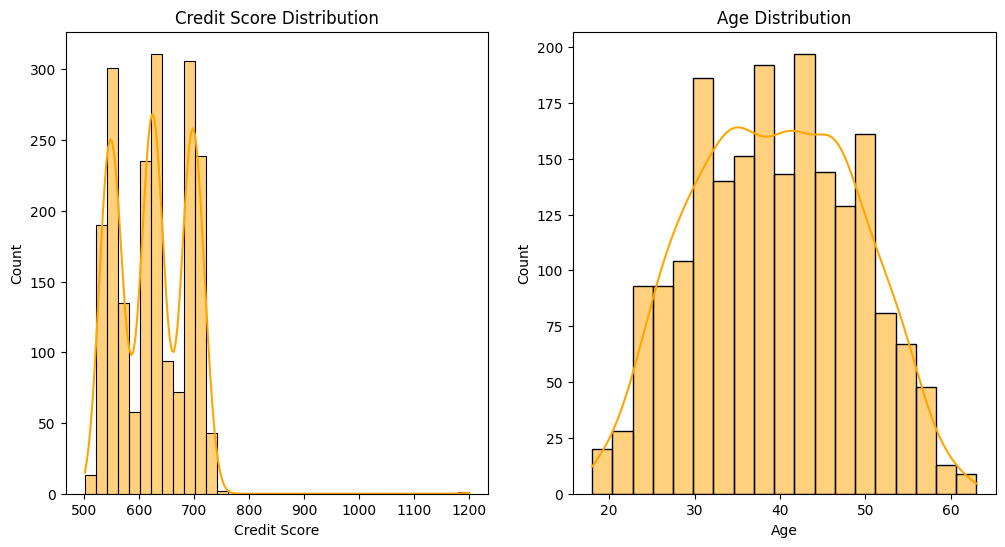

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['credit_score'], kde=True, ax=ax[0], color = 'orange')
ax[0].set_title('Credit Score Distribution')
ax[0].set_xlabel('Credit Score')
sns.histplot(df['age'], kde=True, ax=ax[1], color = "orange")
ax[1].set_title('Age Distribution')
ax[1].set_xlabel('Age')
plt.show()

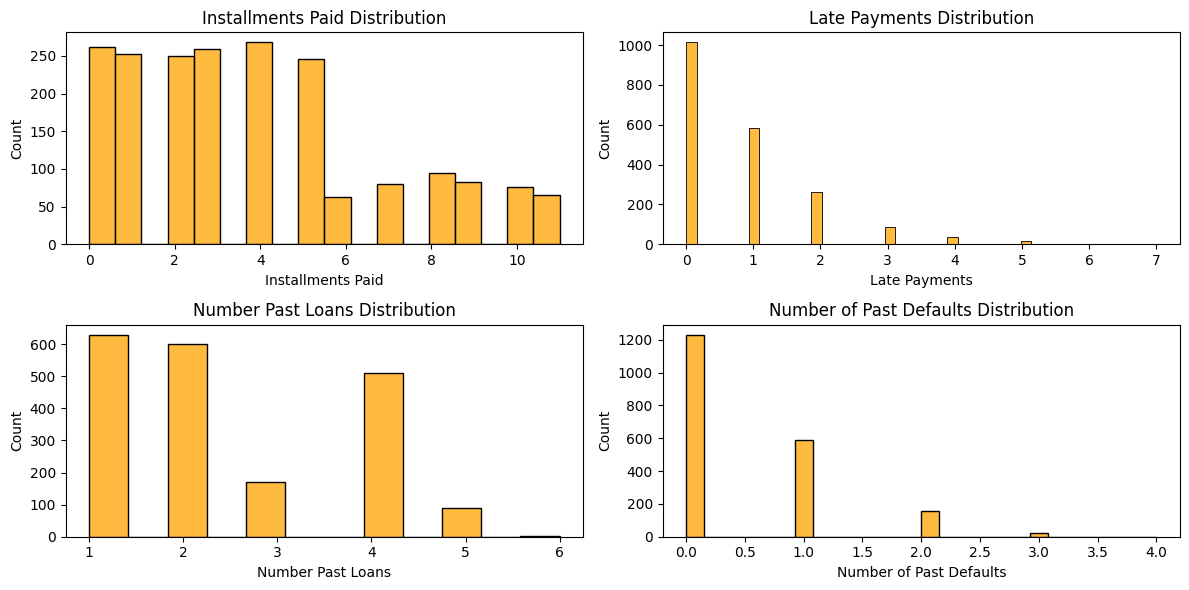

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.histplot(df['installments_paid'], kde=False, ax=ax[0,0], color = "orange")
ax[0,0].set_title('Installments Paid Distribution')
ax[0,0].set_xlabel('Installments Paid')
sns.histplot(df['late_payments'], kde=False, ax=ax[0,1], color = "orange")   
ax[0,1].set_title('Late Payments Distribution')
ax[0,1].set_xlabel('Late Payments')
sns.histplot(df['number_past_loans'], kde=False, ax=ax[1,0], color = "orange")
ax[1,0].set_title('Number Past Loans Distribution')
ax[1,0].set_xlabel('Number Past Loans')
sns.histplot(df['number_past_default'], kde=False, ax=ax[1,1], color = "orange")
ax[1,1].set_title('Number of Past Defaults Distribution')
ax[1,1].set_xlabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

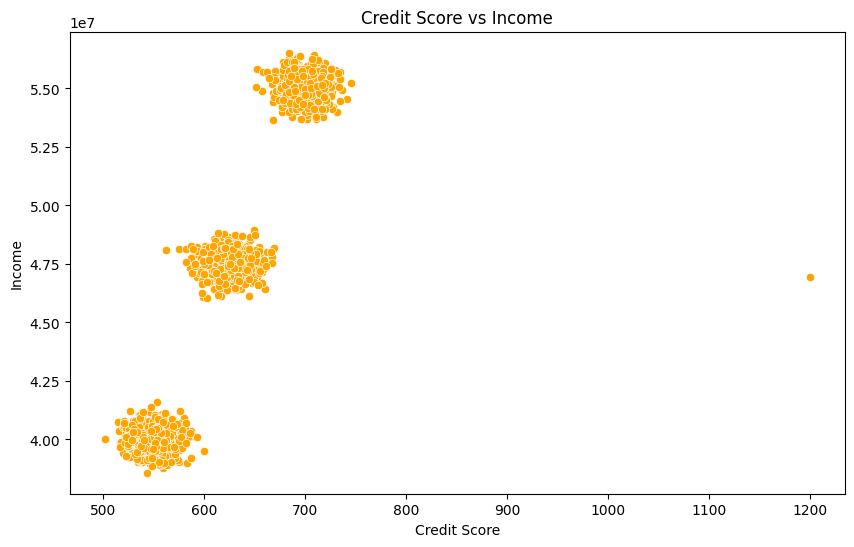

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='credit_score', y='income', data=df, color = "orange")
plt.title('Credit Score vs Income')
plt.xlabel('Credit Score')
plt.ylabel('Income')
plt.show()

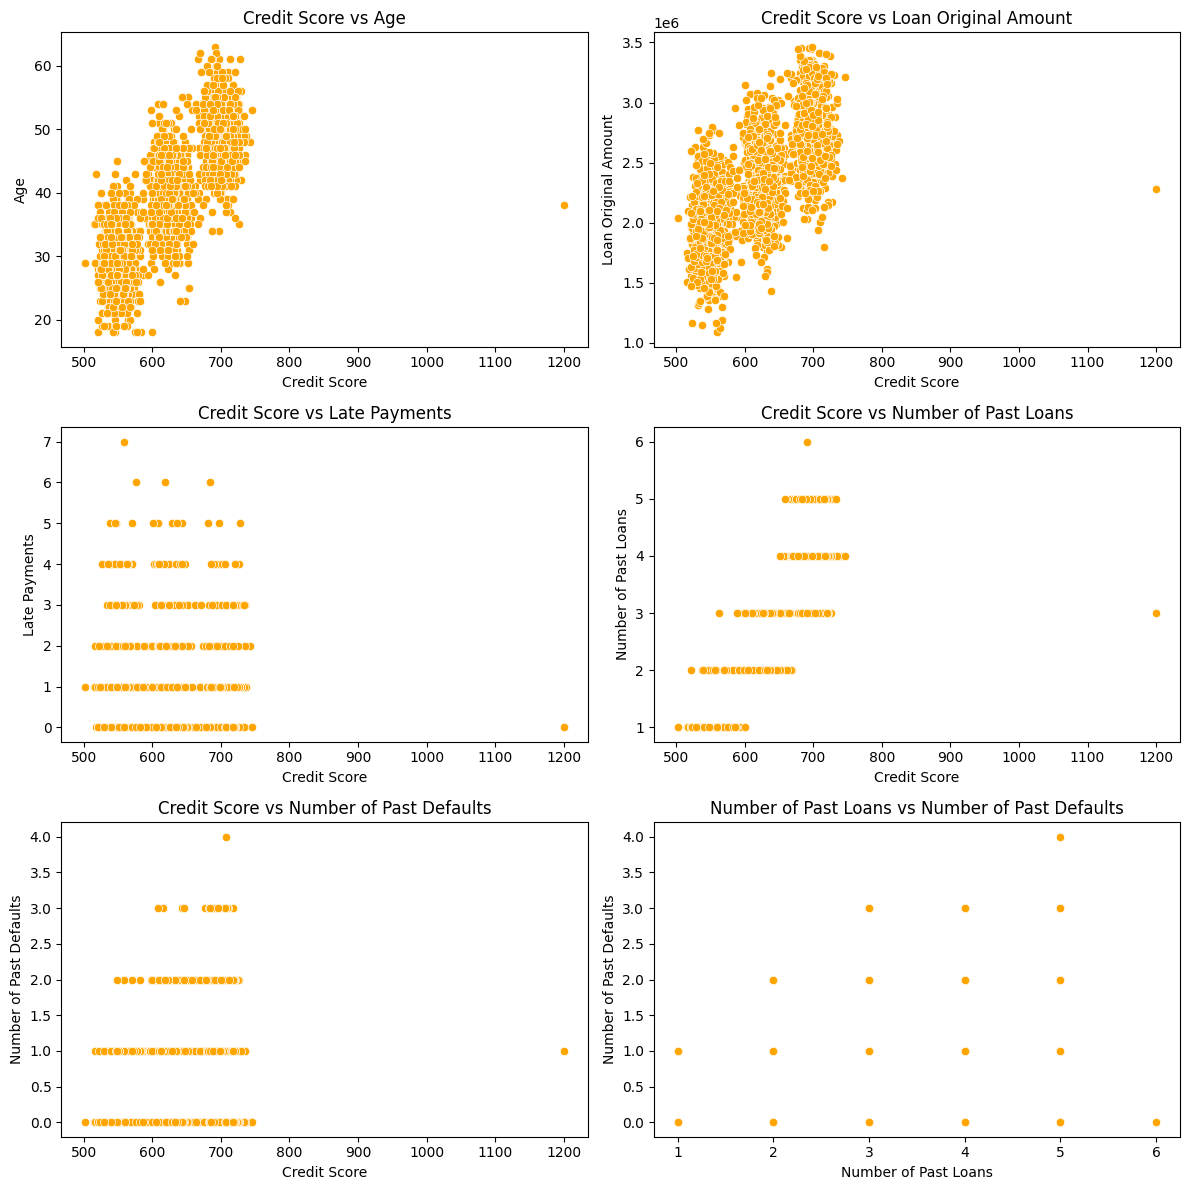

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(x='credit_score', y='age', data=df, ax=ax[0,0], color = "orange")
ax[0,0].set_title('Credit Score vs Age')
ax[0,0].set_xlabel('Credit Score')
ax[0,0].set_ylabel('Age')
sns.scatterplot(x='credit_score', y='loan_orig_amt', data=df, ax=ax[0,1], color = "orange")
ax[0,1].set_title('Credit Score vs Loan Original Amount')
ax[0,1].set_xlabel('Credit Score')
ax[0,1].set_ylabel('Loan Original Amount')
sns.scatterplot(x='credit_score', y='late_payments', data=df, ax=ax[1,0], color = "orange")
ax[1,0].set_title('Credit Score vs Late Payments')
ax[1,0].set_xlabel('Credit Score')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(x='credit_score', y='number_past_loans', data=df, ax=ax[1,1], color = "orange")
ax[1,1].set_title('Credit Score vs Number of Past Loans')
ax[1,1].set_xlabel('Credit Score')
ax[1,1].set_ylabel('Number of Past Loans')
sns.scatterplot(x='credit_score', y='number_past_default', data=df, ax=ax[2,0], color = "orange")
ax[2,0].set_title('Credit Score vs Number of Past Defaults')
ax[2,0].set_xlabel('Credit Score')
ax[2,0].set_ylabel('Number of Past Defaults')
sns.scatterplot(x='number_past_loans', y='number_past_default', data=df, ax=ax[2,1], color = "orange")
ax[2,1].set_title('Number of Past Loans vs Number of Past Defaults')
ax[2,1].set_xlabel('Number of Past Loans')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

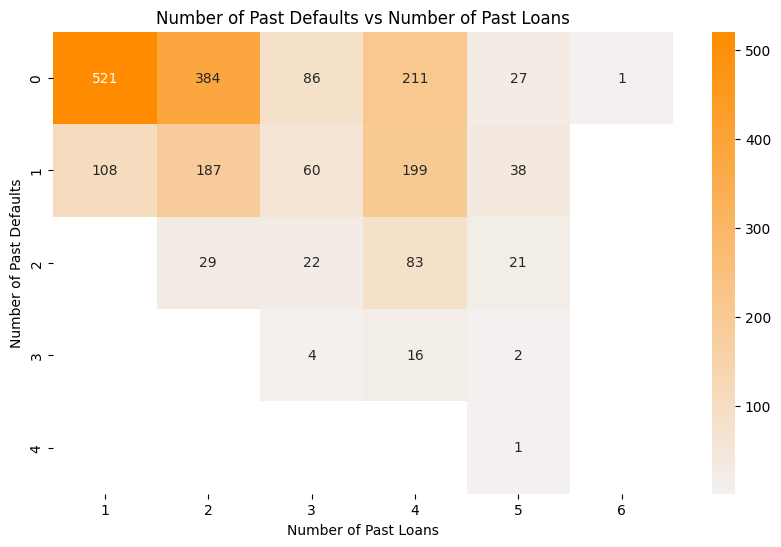

In [16]:
#heat map of number of past defaults and number of past loans flipped
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby(['number_past_default', 'number_past_loans']).size().unstack(), cmap=sns.light_palette("darkorange", as_cmap = True), annot=True, fmt='g')
plt.title('Number of Past Defaults vs Number of Past Loans')
plt.xlabel('Number of Past Loans')
plt.ylabel('Number of Past Defaults')
plt.show()

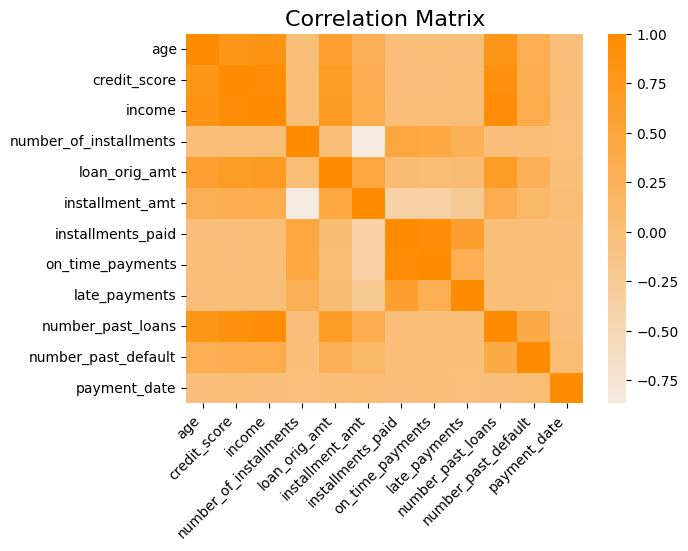

In [17]:
numerical = df.select_dtypes(include=[np.number]).drop(columns=['user_id'])
corr = numerical.corr()
ax = sns.heatmap(corr,  cmap=sns.light_palette("darkorange", as_cmap = True), center=0)
ax.set_title('Correlation Matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Module 4: Data Cleaning

### Irrelevant Columns and Observations

In [18]:
data = df.copy()

In [19]:
data = data[data['account_open'] == True].drop(columns=['payment_date', 'account_open', 'on_time_payments', 'installment_amt'])

### Missing Observations

In [20]:
print(data.shape)
data = data.dropna()
print(data.shape)

(1900, 13)
(1899, 13)


### Outliers



In [21]:
numeric_vars = data.select_dtypes(include=[np.number]).columns
numeric_vars = numeric_vars.drop(['user_id'])
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = (data[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,data['outliers'].sum(), "outlier(s).")

The variable age has 0 outlier(s).
The variable credit_score has 1 outlier(s).
The variable income has 0 outlier(s).
The variable number_of_installments has 0 outlier(s).
The variable loan_orig_amt has 1 outlier(s).
The variable installments_paid has 0 outlier(s).
The variable late_payments has 50 outlier(s).
The variable number_past_loans has 0 outlier(s).
The variable number_past_default has 20 outlier(s).


In [22]:
print("Data has", data.shape[0], "observations to begin.")
data['outliers'] = False
for var in numeric_vars:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = data['outliers'] | ((data[var] - mean).abs() > 3*sd)
#drop outliers
data = data[data['outliers'] == False].drop(columns=['outliers'])
print("Data now has", data.shape[0], "observations after dropping the outliers .")

Data has 1899 observations to begin.
Data now has 1827 observations after dropping the outliers .


### Duplicate Values

In [47]:
duplicates = data[data.duplicated(keep=False)]
print(duplicates.shape[0], "duplicates found.")
duplicates

0 duplicates found.


,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default


In [24]:
print(data.shape)
data = data.drop_duplicates(subset=data.columns.difference(['user_id'])).reset_index(drop=True)
print(data.shape)

(1827, 13)
(1827, 13)


## Module 5: Feature Engineering

### Standardize Continuous Features

In [25]:
numeric_vars = data.select_dtypes(include=[np.number]).columns
numeric_vars = numeric_vars.drop(['user_id'])
df_scaled = data.copy()
scaler = StandardScaler()
df_scaled[numeric_vars]  = scaler.fit_transform(df_scaled[numeric_vars])
df_scaled.head()

,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,3,1.14,male,Bogota,1.40,1.24,1.04,1.69,0.77,1.48,False,1.25,2.42
1,4,-0.67,female,Cartagena,-1.27,-1.14,1.04,-0.83,-1.28,-0.82,False,-1.09,-0.71
2,5,0.39,male,Bogota,1.35,1.19,-0.96,0.42,-0.25,0.33,False,1.25,0.85
3,6,1.46,female,Bogota,1.62,1.28,-0.96,2.06,-0.59,-0.82,False,2.03,-0.71
4,7,-0.67,male,Medellin,0.11,0.01,1.04,0.45,-0.59,0.33,False,-0.31,0.85


In [26]:
print(df_scaled['credit_score'].describe())
print(df_scaled['income'].describe())

count   1827.00
mean       0.00
std        1.00
min       -1.96
25%       -1.03
50%        0.01
75%        1.03
max        1.96
Name: credit_score, dtype: float64
count   1827.00
mean       0.00
std        1.00
min       -1.46
25%       -1.17
50%        0.01
75%        1.18
max        1.46
Name: income, dtype: float64


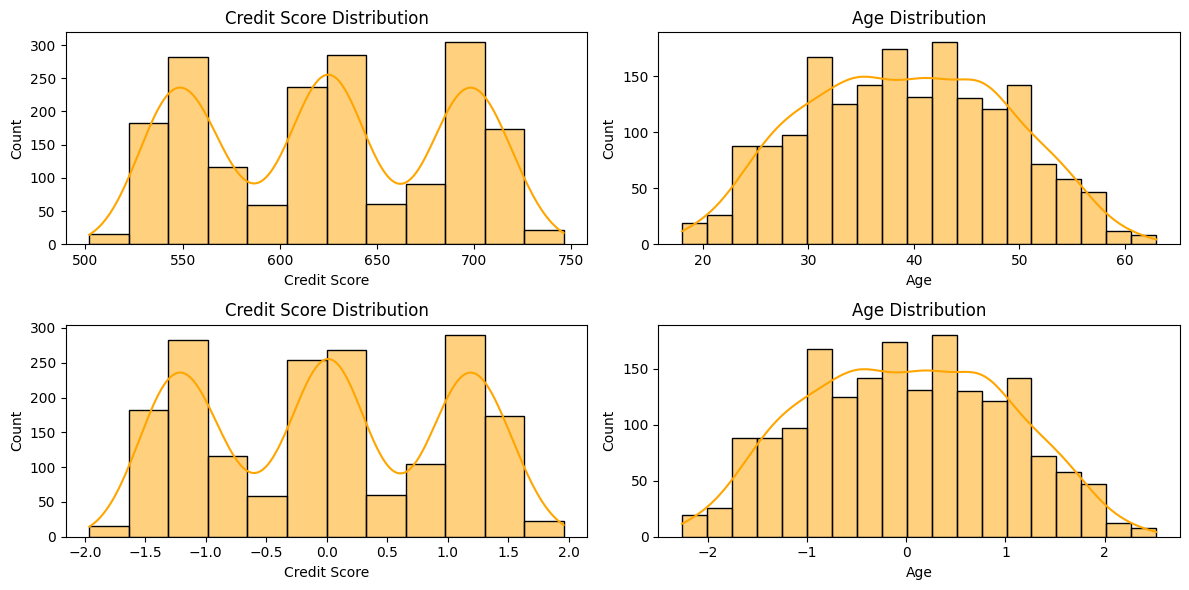

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
sns.histplot(data['credit_score'], kde=True, color = 'orange', ax=ax[0,0])
ax[0,0].set_title('Credit Score Distribution')
ax[0,0].set_xlabel('Credit Score')
sns.histplot(data['age'], kde=True, color = "orange", ax=ax[0,1])
ax[0,1].set_title('Age Distribution')
ax[0,1].set_xlabel('Age')
sns.histplot(df_scaled['credit_score'], kde=True, color = 'orange', ax=ax[1,0])
ax[1,0].set_title('Credit Score Distribution')
ax[1,0].set_xlabel('Credit Score')
sns.histplot(df_scaled['age'], kde=True, color = "orange",  ax=ax[1,1])
ax[1,1].set_title('Age Distribution')
ax[1,1].set_xlabel('Age')
plt.tight_layout()
plt.show()

### One Hot Encoding Categorial Features

In [28]:
for vars in ['account_delq']:
    df_scaled[vars] = df_scaled[vars].astype('object')

obj_cols = df_scaled.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = encoder.fit_transform(df_scaled[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the scaled dataframe
df_encoded = pd.concat([df_scaled, one_hot_df], axis=1)
print(df_encoded.shape)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
df_encoded.head()

(1827, 17)


,user_id,age,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,number_past_loans,number_past_default,gender_male,location_Cartagena,location_Medellin,account_delq_True
0,3,1.14,1.40,1.24,1.04,1.69,0.77,1.48,1.25,2.42,1.00,0.00,0.00,0.00
1,4,-0.67,-1.27,-1.14,1.04,-0.83,-1.28,-0.82,-1.09,-0.71,0.00,1.00,0.00,0.00
2,5,0.39,1.35,1.19,-0.96,0.42,-0.25,0.33,1.25,0.85,1.00,0.00,0.00,0.00
3,6,1.46,1.62,1.28,-0.96,2.06,-0.59,-0.82,2.03,-0.71,0.00,0.00,0.00,0.00
4,7,-0.67,0.11,0.01,1.04,0.45,-0.59,0.33,-0.31,0.85,1.00,0.00,1.00,0.00


In [29]:
data_for_clustering_means = df_encoded.drop(columns=['user_id'])

## Module 6: Segmentation Techniques and Models: K Means Clustering 

### Example

In [30]:
kmeans = KMeans(n_clusters=3, init= "random", n_init= 10, max_iter= 300, random_state= 42)
cluster_labels = kmeans.fit_predict(data_for_clustering_means)

In [31]:
data_clusters_example = pd.concat([pd.DataFrame({'cluster': cluster_labels}), data], axis=1)
print(data_clusters_example.shape)
data_clusters_example.head()

(1827, 14)


,cluster,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,0,3,50.00,male,Bogota,711,55060072.07,12,3084222.42,6,2,False,4,2
1,2,4,33.00,female,Cartagena,545,40542930.85,12,2020920.77,0,0,False,1,0
2,0,5,43.00,male,Bogota,708,54729839.35,6,2549207.00,3,1,False,4,1
3,0,6,53.00,female,Bogota,725,55289607.35,6,3240824.16,2,0,False,5,0
4,1,7,33.00,male,Medellin,631,47570085.23,12,2562102.69,2,1,False,2,1


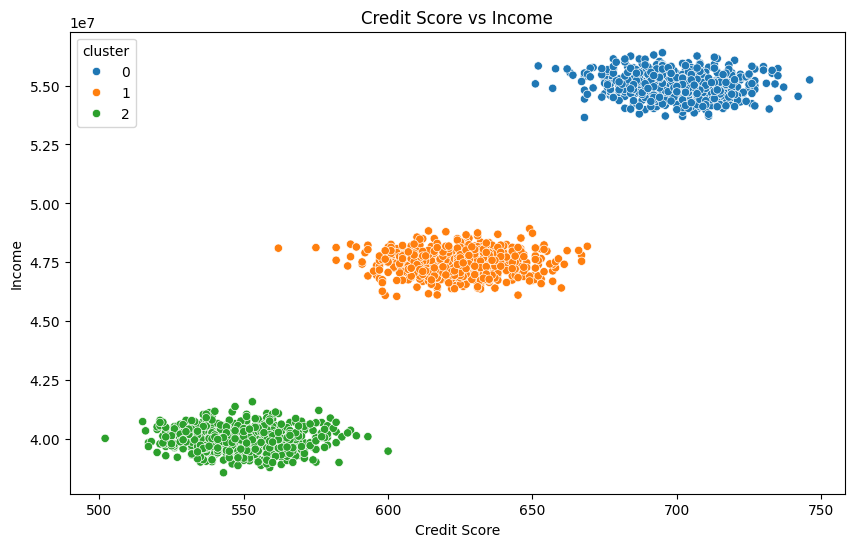

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='credit_score', y='income', data=data_clusters_example, hue = 'cluster', palette = 'tab10')
plt.title('Credit Score vs Income')
plt.xlabel('Credit Score')
plt.ylabel('Income')
plt.show()

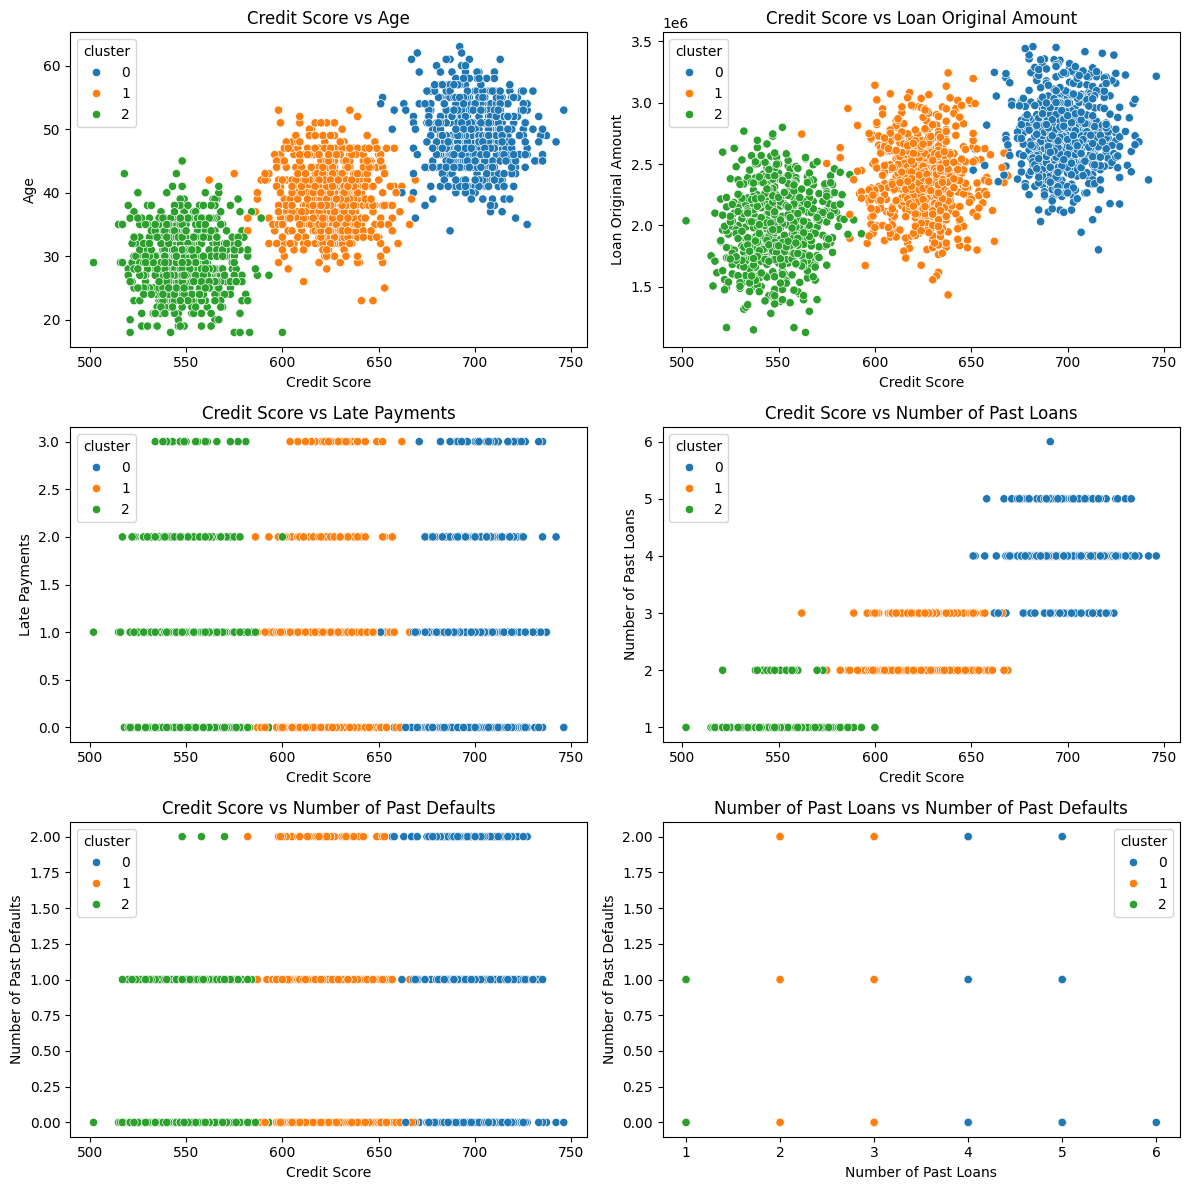

In [33]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(x='credit_score', y='age', data=data_clusters_example, ax=ax[0,0], hue = 'cluster', palette = 'tab10')
ax[0,0].set_title('Credit Score vs Age')
ax[0,0].set_xlabel('Credit Score')
ax[0,0].set_ylabel('Age')
sns.scatterplot(x='credit_score', y='loan_orig_amt', data=data_clusters_example, ax=ax[0,1], hue = 'cluster', palette = 'tab10')
ax[0,1].set_title('Credit Score vs Loan Original Amount')
ax[0,1].set_xlabel('Credit Score')
ax[0,1].set_ylabel('Loan Original Amount')
sns.scatterplot(x='credit_score', y='late_payments', data=data_clusters_example, ax=ax[1,0], hue = 'cluster', palette = 'tab10')
ax[1,0].set_title('Credit Score vs Late Payments')
ax[1,0].set_xlabel('Credit Score')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(x='credit_score', y='number_past_loans', data=data_clusters_example, ax=ax[1,1], hue = 'cluster', palette = 'tab10')
ax[1,1].set_title('Credit Score vs Number of Past Loans')
ax[1,1].set_xlabel('Credit Score')
ax[1,1].set_ylabel('Number of Past Loans')
sns.scatterplot(x='credit_score', y='number_past_default', data=data_clusters_example, ax=ax[2,0], hue = 'cluster', palette = 'tab10')
ax[2,0].set_title('Credit Score vs Number of Past Defaults')
ax[2,0].set_xlabel('Credit Score')
ax[2,0].set_ylabel('Number of Past Defaults')
sns.scatterplot(x='number_past_loans', y='number_past_default', data=data_clusters_example, ax=ax[2,1], hue = 'cluster', palette = 'tab10')
ax[2,1].set_title('Number of Past Loans vs Number of Past Defaults')
ax[2,1].set_xlabel('Number of Past Loans')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

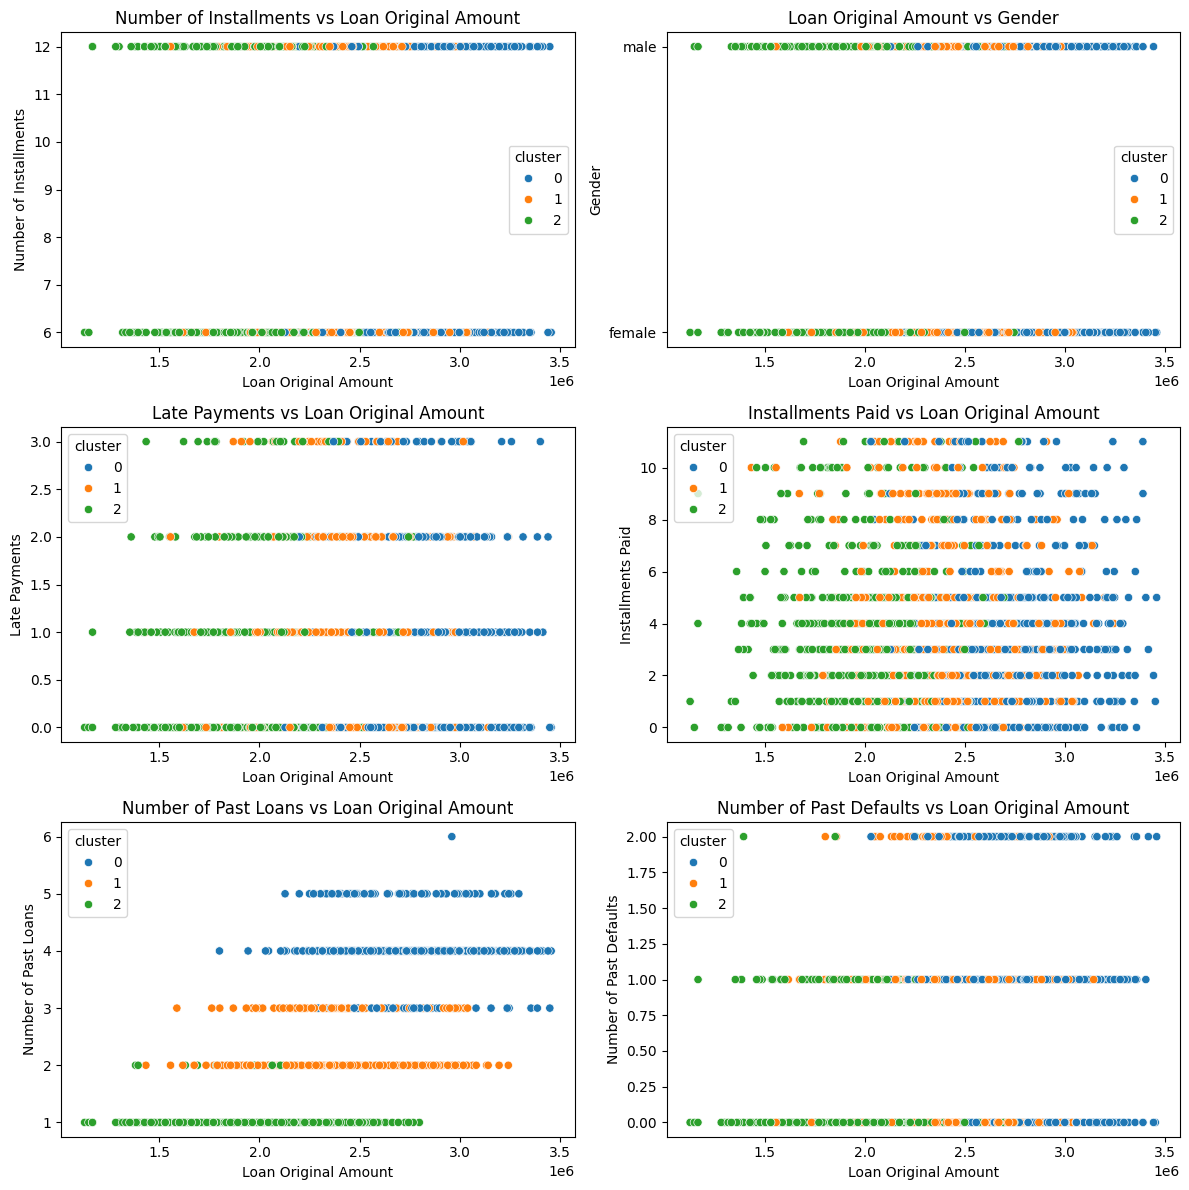

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(data=data_clusters_example, y='number_of_installments', x='loan_orig_amt', hue='cluster', ax=ax[0, 0], palette = 'tab10')
ax[0,0].set_title('Number of Installments vs Loan Original Amount')
ax[0,0].set_xlabel('Loan Original Amount')
ax[0,0].set_ylabel('Number of Installments')
sns.scatterplot(data=data_clusters_example, y='gender', x='loan_orig_amt', hue='cluster', ax=ax[0, 1], palette = 'tab10')
ax[0,1].set_title('Loan Original Amount vs Gender')
ax[0,1].set_xlabel('Loan Original Amount')
ax[0,1].set_ylabel('Gender')
sns.scatterplot(data=data_clusters_example, y='late_payments', x='loan_orig_amt', hue='cluster', ax=ax[1, 0], palette = 'tab10')
ax[1,0].set_title('Late Payments vs Loan Original Amount')
ax[1,0].set_xlabel('Loan Original Amount')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(data=data_clusters_example, y='installments_paid', x='loan_orig_amt', hue='cluster', ax=ax[1, 1], palette = 'tab10')
ax[1,1].set_title('Installments Paid vs Loan Original Amount')
ax[1,1].set_xlabel('Loan Original Amount')
ax[1,1].set_ylabel('Installments Paid')
sns.scatterplot(data=data_clusters_example, y='number_past_loans', x='loan_orig_amt', hue='cluster', ax=ax[2, 0], palette = 'tab10')
ax[2,0].set_title('Number of Past Loans vs Loan Original Amount')
ax[2,0].set_xlabel('Loan Original Amount')
ax[2,0].set_ylabel('Number of Past Loans')
sns.scatterplot(data=data_clusters_example, y='number_past_default', x='loan_orig_amt', hue='cluster', ax=ax[2, 1], palette = 'tab10')
ax[2,1].set_title('Number of Past Defaults vs Loan Original Amount')
ax[2,1].set_xlabel('Loan Original Amount')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

### Determining the Number of Clusters

In [35]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_7028/2220118858.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax[0].plot(range(2, 11), silhouette_avg, 'bx-', color = 'orange')
/var/folders/cd/yhbft8yj611dsg2rkjqhhsv00000gn/T/ipykernel_7028/2220118858.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  ax[1].plot(range(2, 11), sse, 'bx-', color = 'orange')


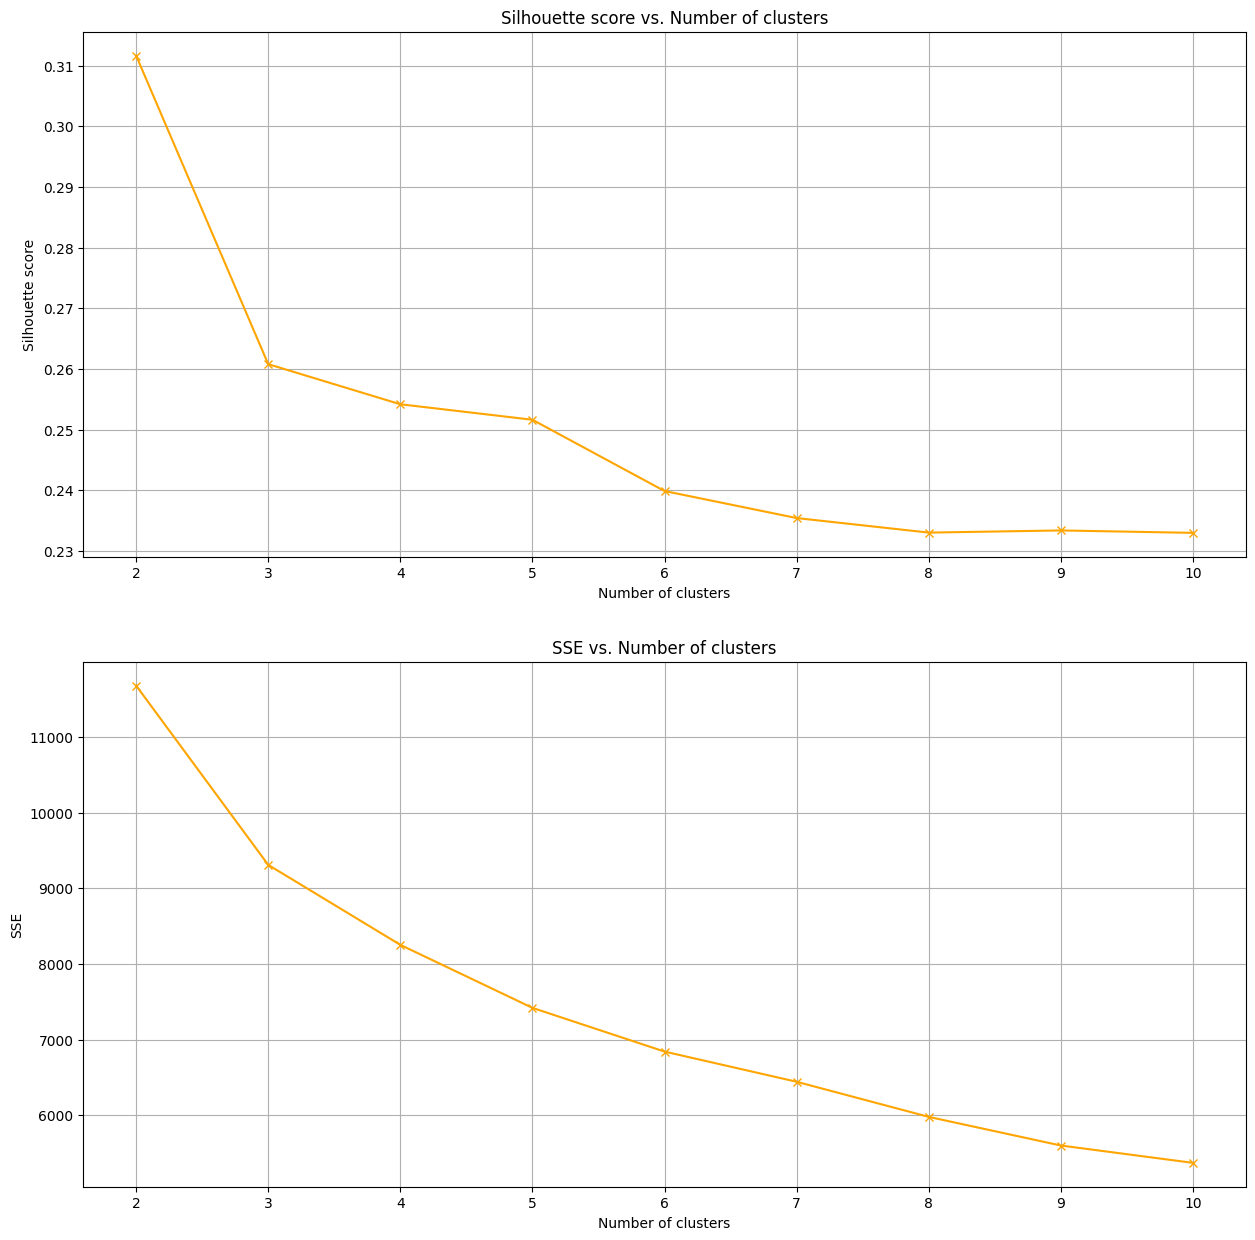

In [36]:
sse = []
silhouette_avg = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init= 'k-means++', n_init= 10, max_iter= 300, random_state= 42)
    cluster_labels = kmeans.fit_predict(data_for_clustering_means)
    sse.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(data_for_clustering_means, cluster_labels))

fig, ax = plt.subplots(2,1, figsize=(15, 15))
ax[0].plot(range(2, 11), silhouette_avg, 'bx-', color = 'orange')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score')
ax[0].set_title('Silhouette score vs. Number of clusters')
ax[0].grid()
ax[1].plot(range(2, 11), sse, 'bx-', color = 'orange')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('SSE')
ax[1].set_title('SSE vs. Number of clusters')
ax[1].grid()
plt.show()


In [38]:
kmeans = KMeans(n_clusters=6, init= "random", n_init= 10, max_iter= 300, random_state= 42)
cluster_labels = kmeans.fit_predict(data_for_clustering_means)
data_clusters_test = pd.concat([pd.DataFrame({'cluster': cluster_labels}), data], axis=1)
print(data_clusters_test.shape)
data_clusters_test.head()

(1827, 14)


,cluster,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,4,3,50.00,male,Bogota,711,55060072.07,12,3084222.42,6,2,False,4,2
1,5,4,33.00,female,Cartagena,545,40542930.85,12,2020920.77,0,0,False,1,0
2,2,5,43.00,male,Bogota,708,54729839.35,6,2549207.00,3,1,False,4,1
3,2,6,53.00,female,Bogota,725,55289607.35,6,3240824.16,2,0,False,5,0
4,1,7,33.00,male,Medellin,631,47570085.23,12,2562102.69,2,1,False,2,1


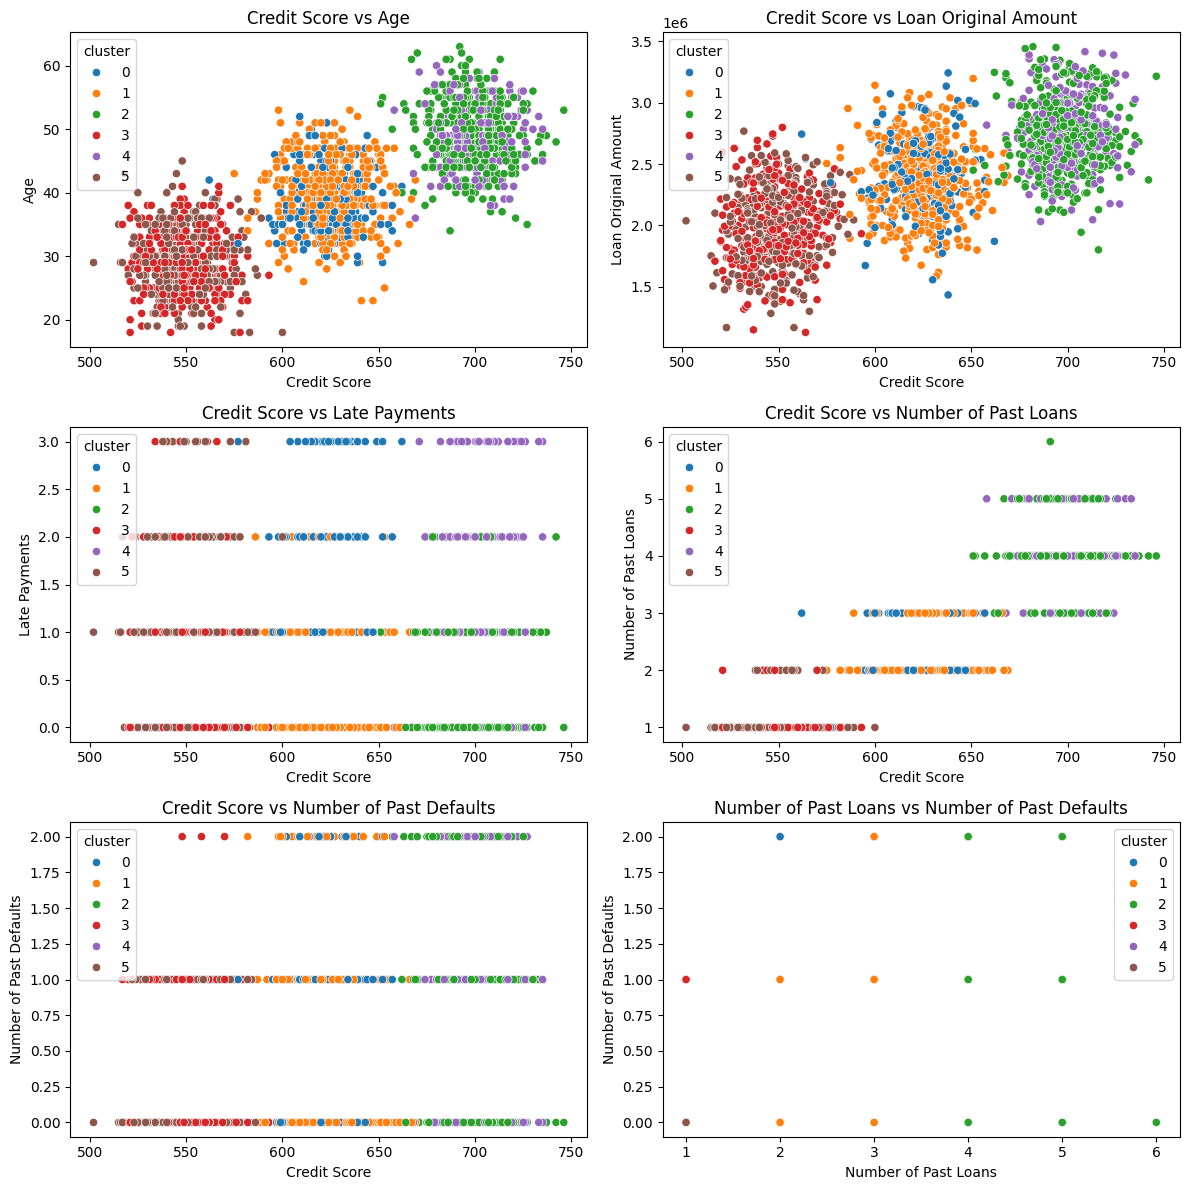

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(x='credit_score', y='age', data=data_clusters_test, ax=ax[0,0], hue = 'cluster', palette = 'tab10')
ax[0,0].set_title('Credit Score vs Age')
ax[0,0].set_xlabel('Credit Score')
ax[0,0].set_ylabel('Age')
sns.scatterplot(x='credit_score', y='loan_orig_amt', data=data_clusters_test, ax=ax[0,1], hue = 'cluster', palette = 'tab10')
ax[0,1].set_title('Credit Score vs Loan Original Amount')
ax[0,1].set_xlabel('Credit Score')
ax[0,1].set_ylabel('Loan Original Amount')
sns.scatterplot(x='credit_score', y='late_payments', data=data_clusters_test, ax=ax[1,0], hue = 'cluster', palette = 'tab10')
ax[1,0].set_title('Credit Score vs Late Payments')
ax[1,0].set_xlabel('Credit Score')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(x='credit_score', y='number_past_loans', data=data_clusters_test, ax=ax[1,1], hue = 'cluster', palette = 'tab10')
ax[1,1].set_title('Credit Score vs Number of Past Loans')
ax[1,1].set_xlabel('Credit Score')
ax[1,1].set_ylabel('Number of Past Loans')
sns.scatterplot(x='credit_score', y='number_past_default', data=data_clusters_test, ax=ax[2,0], hue = 'cluster', palette = 'tab10')
ax[2,0].set_title('Credit Score vs Number of Past Defaults')
ax[2,0].set_xlabel('Credit Score')
ax[2,0].set_ylabel('Number of Past Defaults')
sns.scatterplot(x='number_past_loans', y='number_past_default', data=data_clusters_test, ax=ax[2,1], hue = 'cluster', palette = 'tab10')
ax[2,1].set_title('Number of Past Loans vs Number of Past Defaults')
ax[2,1].set_xlabel('Number of Past Loans')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

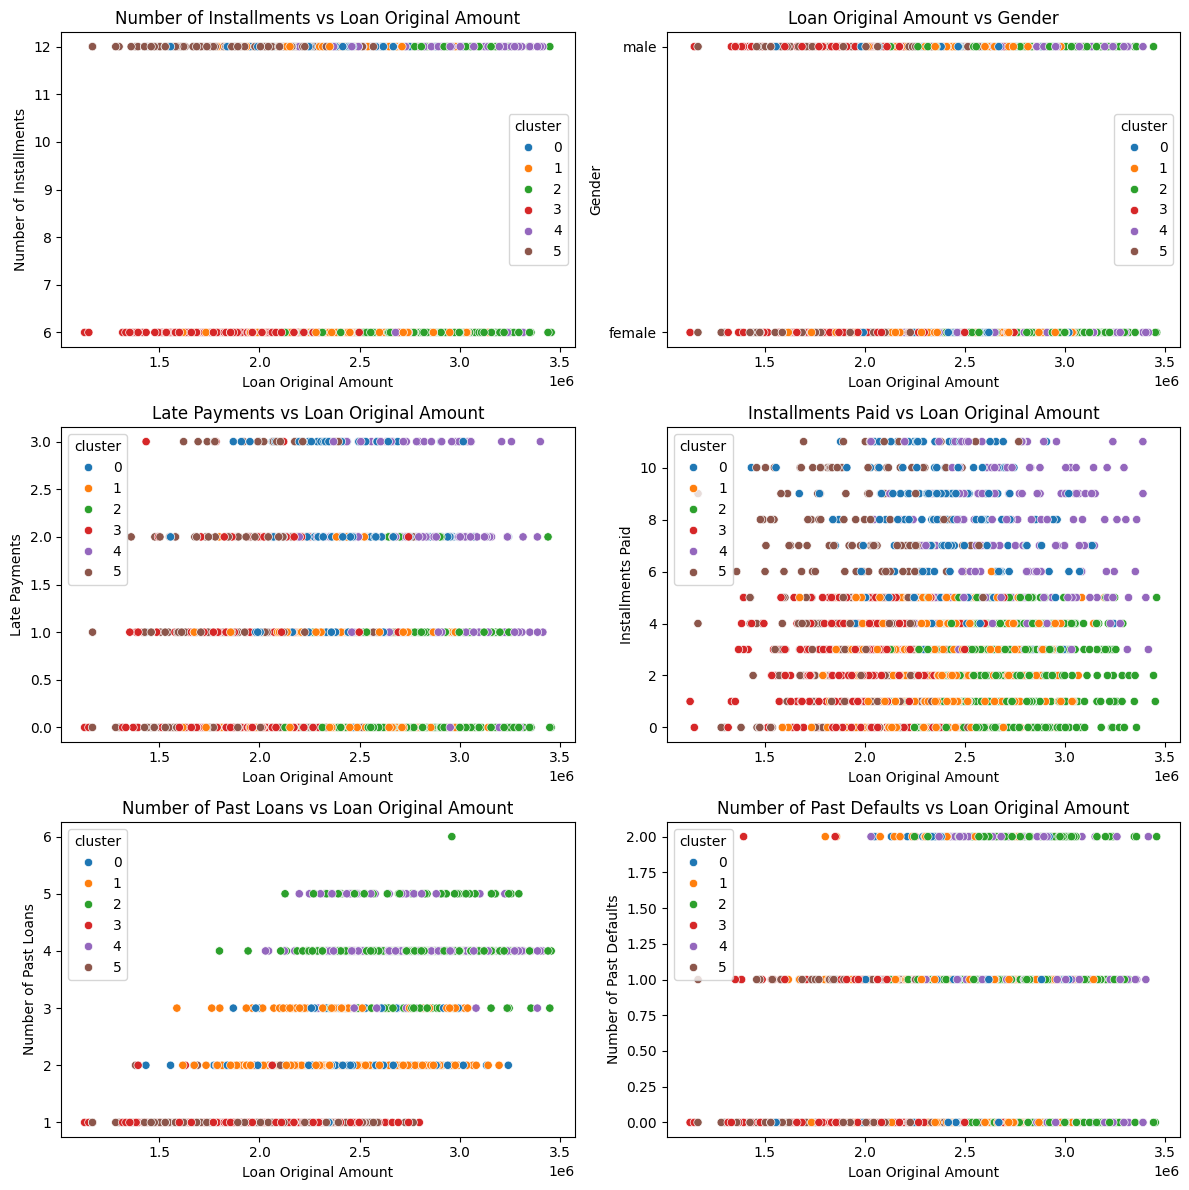

In [40]:
#plot clusters
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.scatterplot(data=data_clusters_test, y='number_of_installments', x='loan_orig_amt', hue='cluster', ax=ax[0, 0], palette = 'tab10')
ax[0,0].set_title('Number of Installments vs Loan Original Amount')
ax[0,0].set_xlabel('Loan Original Amount')
ax[0,0].set_ylabel('Number of Installments')
sns.scatterplot(data=data_clusters_test, y='gender', x='loan_orig_amt', hue='cluster', ax=ax[0, 1], palette = 'tab10')
ax[0,1].set_title('Loan Original Amount vs Gender')
ax[0,1].set_xlabel('Loan Original Amount')
ax[0,1].set_ylabel('Gender')
sns.scatterplot(data=data_clusters_test, y='late_payments', x='loan_orig_amt', hue='cluster', ax=ax[1, 0], palette = 'tab10')
ax[1,0].set_title('Late Payments vs Loan Original Amount')
ax[1,0].set_xlabel('Loan Original Amount')
ax[1,0].set_ylabel('Late Payments')
sns.scatterplot(data=data_clusters_test, y='installments_paid', x='loan_orig_amt', hue='cluster', ax=ax[1, 1], palette = 'tab10')
ax[1,1].set_title('Installments Paid vs Loan Original Amount')
ax[1,1].set_xlabel('Loan Original Amount')
ax[1,1].set_ylabel('Installments Paid')
sns.scatterplot(data=data_clusters_test, y='number_past_loans', x='loan_orig_amt', hue='cluster', ax=ax[2, 0], palette = 'tab10')
ax[2,0].set_title('Number of Past Loans vs Loan Original Amount')
ax[2,0].set_xlabel('Loan Original Amount')
ax[2,0].set_ylabel('Number of Past Loans')
sns.scatterplot(data=data_clusters_test, y='number_past_default', x='loan_orig_amt', hue='cluster', ax=ax[2, 1], palette = 'tab10')
ax[2,1].set_title('Number of Past Defaults vs Loan Original Amount')
ax[2,1].set_xlabel('Loan Original Amount')
ax[2,1].set_ylabel('Number of Past Defaults')
plt.tight_layout()
plt.show()

### Characterizing Clusters

In [41]:
kmeans = KMeans(n_clusters=3, init= "random", n_init= 10, max_iter= 300, random_state= 42)
cluster_labels = kmeans.fit_predict(data_for_clustering_means)
data_clusters = pd.concat([pd.DataFrame({'cluster': cluster_labels}), data], axis=1)
print(data_clusters.shape)
data_clusters.head()

(1827, 14)


,cluster,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,0,3,50.00,male,Bogota,711,55060072.07,12,3084222.42,6,2,False,4,2
1,2,4,33.00,female,Cartagena,545,40542930.85,12,2020920.77,0,0,False,1,0
2,0,5,43.00,male,Bogota,708,54729839.35,6,2549207.00,3,1,False,4,1
3,0,6,53.00,female,Bogota,725,55289607.35,6,3240824.16,2,0,False,5,0
4,1,7,33.00,male,Medellin,631,47570085.23,12,2562102.69,2,1,False,2,1


In [42]:
df_analysis = data_clusters.copy()
df_analysis = df_analysis.groupby('cluster').agg({'age': 'mean', 'income': 'mean', 'credit_score': 'mean', 'number_of_installments': 'mean', 
                                                  'loan_orig_amt': 'mean',  'installments_paid': 'mean', 
                                                  'late_payments': 'mean', 'account_delq': 'mean', 'number_past_loans': 'mean',
                                                  'number_past_default':'mean'}).reset_index()

df_analysis['income'] = df_analysis['income']/1000000
df_analysis['loan_orig_amt'] = df_analysis['loan_orig_amt']/1000000
df_analysis = df_analysis.round(0)
df_analysis

,cluster,age,income,credit_score,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default
0,0,49.00,55.00,699.00,9.00,3.00,4.00,1.00,0.00,4.00,1.00
1,1,39.00,47.00,625.00,9.00,2.00,4.00,1.00,0.00,2.00,0.00
2,2,29.00,40.00,549.00,9.00,2.00,4.00,1.00,0.00,1.00,0.00


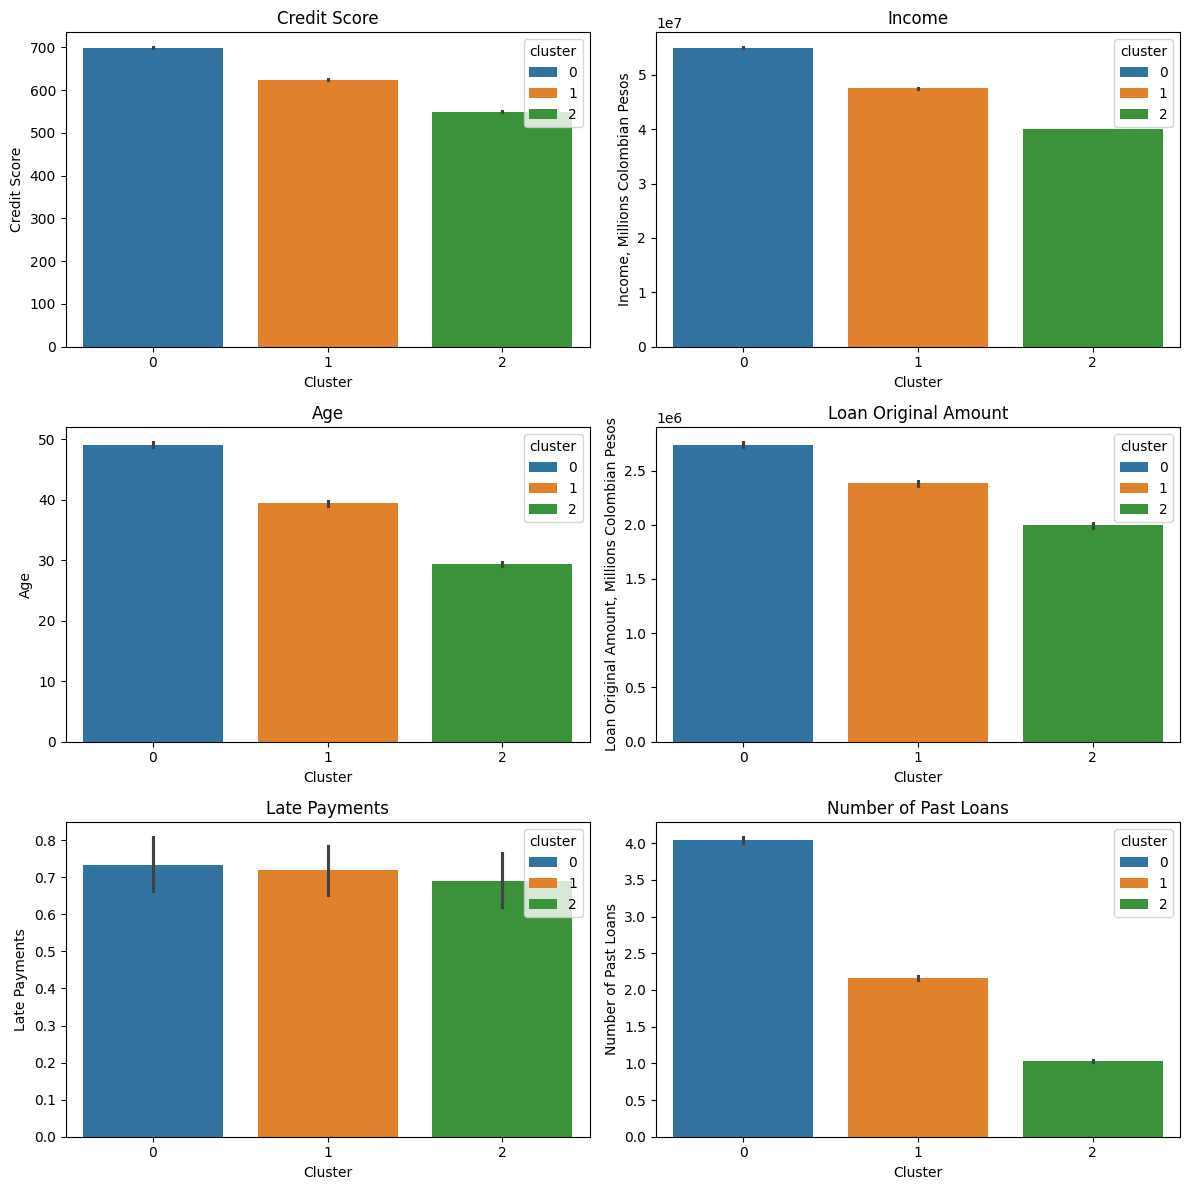

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
sns.barplot(x='cluster', y='credit_score', data=data_clusters, ax=ax[0,0], palette = 'tab10', hue='cluster')
ax[0,0].set_title('Credit Score')
ax[0,0].set_xlabel('Cluster')
ax[0,0].set_ylabel('Credit Score')
sns.barplot(x='cluster', y='income', data=data_clusters, ax=ax[0,1], palette = 'tab10', hue='cluster')
ax[0,1].set_title('Income')
ax[0,1].set_xlabel('Cluster')
ax[0,1].set_ylabel('Income, Millions Colombian Pesos')
sns.barplot(x='cluster', y='age', data=data_clusters, ax=ax[1,0], palette = 'tab10', hue='cluster')
ax[1,0].set_title('Age')
ax[1,0].set_xlabel('Cluster')
ax[1,0].set_ylabel('Age')
sns.barplot(x='cluster', y='loan_orig_amt', data=data_clusters, ax=ax[1,1], palette = 'tab10', hue='cluster')
ax[1,1].set_title('Loan Original Amount')
ax[1,1].set_xlabel('Cluster')
ax[1,1].set_ylabel('Loan Original Amount, Millions Colombian Pesos')
sns.barplot(x='cluster', y='late_payments', data=data_clusters, ax=ax[2,0], palette = 'tab10', hue='cluster')
ax[2,0].set_title('Late Payments')
ax[2,0].set_xlabel('Cluster')
ax[2,0].set_ylabel('Late Payments')
sns.barplot(x='cluster', y='number_past_loans', data=data_clusters, ax=ax[2,1], palette = 'tab10', hue='cluster')
ax[2,1].set_title('Number of Past Loans')
ax[2,1].set_xlabel('Cluster')
ax[2,1].set_ylabel('Number of Past Loans')
plt.tight_layout()
plt.show()    

In [44]:
for vars in ['account_delq']:
    data_clusters[vars] = data_clusters[vars].astype('object')

obj_cols = data_clusters.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = encoder.fit_transform(data_clusters[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the scaled dataframe
df_encoded_analysis = pd.concat([data_clusters, one_hot_df], axis=1)
print(df_encoded_analysis.shape)

# Display the resulting dataframe
df_encoded_analysis.head()

(1827, 18)


,cluster,user_id,age,gender,location,credit_score,income,number_of_installments,loan_orig_amt,installments_paid,late_payments,account_delq,number_past_loans,number_past_default,gender_male,location_Cartagena,location_Medellin,account_delq_True
0,0,3,50.00,male,Bogota,711,55060072.07,12,3084222.42,6,2,False,4,2,1.00,0.00,0.00,0.00
1,2,4,33.00,female,Cartagena,545,40542930.85,12,2020920.77,0,0,False,1,0,0.00,1.00,0.00,0.00
2,0,5,43.00,male,Bogota,708,54729839.35,6,2549207.00,3,1,False,4,1,1.00,0.00,0.00,0.00
3,0,6,53.00,female,Bogota,725,55289607.35,6,3240824.16,2,0,False,5,0,0.00,0.00,0.00,0.00
4,1,7,33.00,male,Medellin,631,47570085.23,12,2562102.69,2,1,False,2,1,1.00,0.00,1.00,0.00


In [45]:
df_analysis_cat = df_encoded_analysis.copy()
#group by cluster and calculate the mean for numeric variables
df_analysis_cat = df_analysis_cat.groupby('cluster').agg({'gender_male': 'mean', 'location_Cartagena': 'mean', 'location_Medellin': 'mean', 
                                                  'account_delq_True': 'mean'}).reset_index()

#format to 0 decimal places
df_analysis_cat = df_analysis_cat.round(2)
df_analysis_cat

,cluster,gender_male,location_Cartagena,location_Medellin,account_delq_True
0,0,0.48,0.00,0.00,0.05
1,1,0.50,0.00,1.00,0.04
2,2,0.51,1.00,0.00,0.05


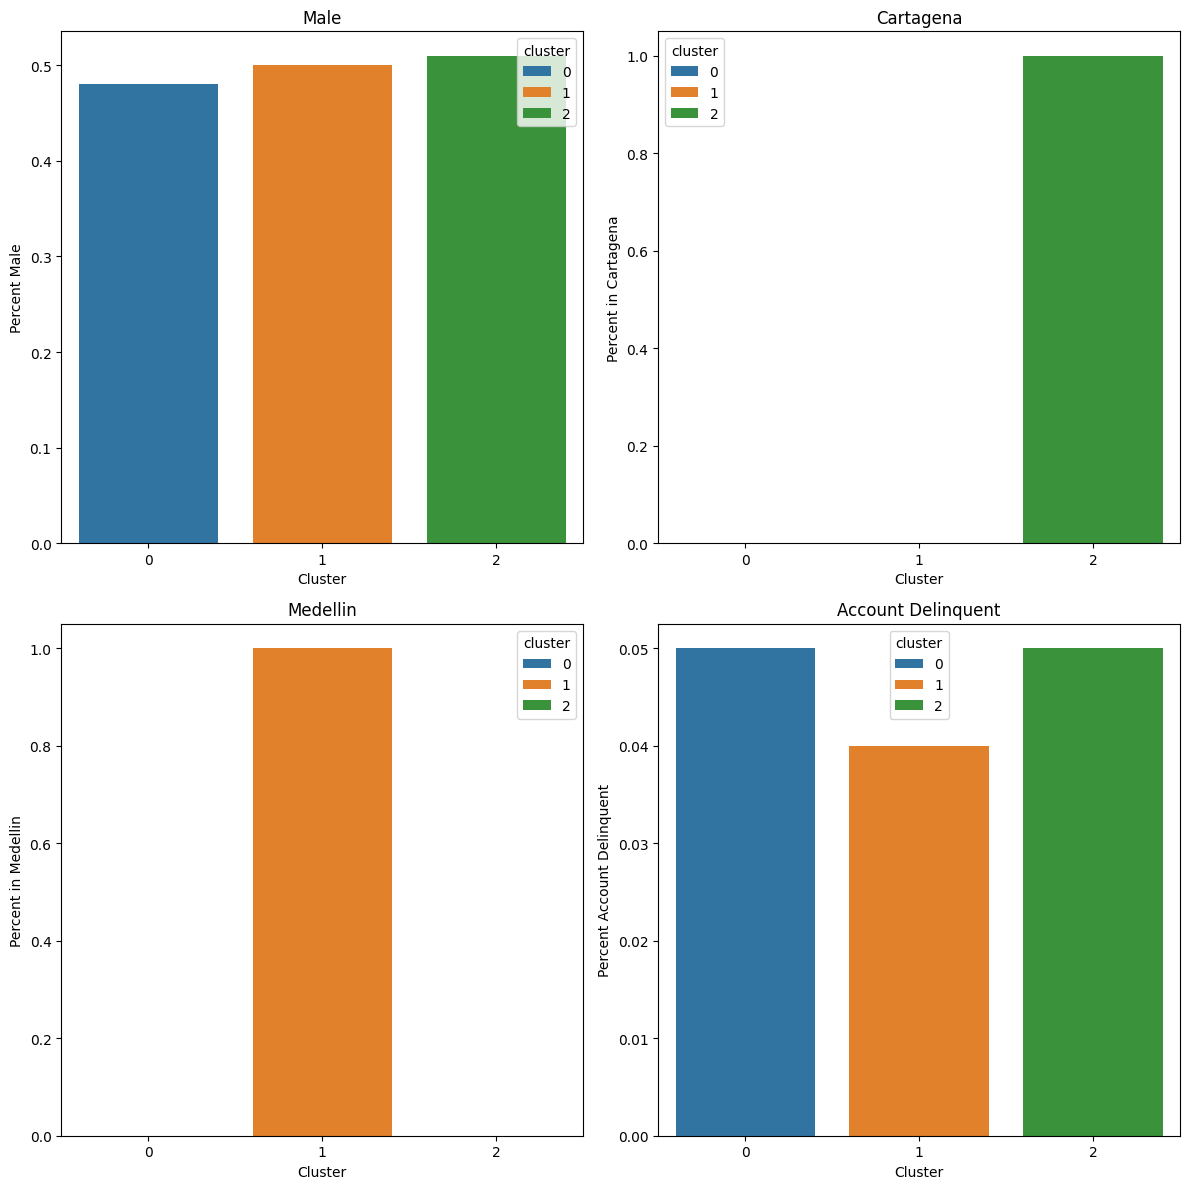

In [46]:
#plot
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
sns.barplot(x='cluster', y='gender_male', data=df_analysis_cat, ax=ax[0,0], palette = 'tab10', hue='cluster')
ax[0,0].set_title('Male')
ax[0,0].set_xlabel('Cluster')
ax[0,0].set_ylabel('Percent Male')
sns.barplot(x='cluster', y='location_Cartagena', data=df_analysis_cat, ax=ax[0,1], palette = 'tab10', hue='cluster')
ax[0,1].set_title('Cartagena')
ax[0,1].set_xlabel('Cluster')
ax[0,1].set_ylabel('Percent in Cartagena')
sns.barplot(x='cluster', y='location_Medellin', data=df_analysis_cat, ax=ax[1,0], palette = 'tab10', hue='cluster')
ax[1,0].set_title('Medellin')
ax[1,0].set_xlabel('Cluster')
ax[1,0].set_ylabel('Percent in Medellin')
sns.barplot(x='cluster', y='account_delq_True', data=df_analysis_cat, ax=ax[1,1], palette = 'tab10', hue='cluster')
ax[1,1].set_title('Account Delinquent')
ax[1,1].set_xlabel('Cluster')
ax[1,1].set_ylabel('Percent Account Delinquent')
plt.tight_layout()
plt.show()    